<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Тестовое задание на позицию аналитик данных


1. Создам датасет с имзменениями, с которыми буду работать. Как указано в тексте задания, изменения должны быть случайными, поэтому реализую это с помощью библиотеки numpy. В дальнейшем анализе и презентации буду использовать данные, которые получатся в ходе рандомизации изменений, поэтому если будут нужны определенные изменения в ингредиентах, то их можно изменить в переменной changes_data. 

In [1]:
# Импортируем библиотеки, с которыми будем работать
import pandas as pd
import numpy as np
from openpyxl import Workbook
from openpyxl.styles import Alignment
import matplotlib.pyplot as plt
import seaborn as sns


# Чтение данных из файла data.xlsx
data_df = pd.read_excel('data.xlsx')

# Получение уникальных ингредиентов из data_df
unique_ingredients = data_df[data_df['cdit_cdit_ID_Parent'].notnull()]['pitm_Name'].unique()

# Случайный выбор изменений
num_changes = 6  # Количество изменений
selected_ingredients = np.random.choice(unique_ingredients, num_changes, replace=False)

# Случайное изменение стоимости (в процентах)
changes_percent = np.random.uniform(-50, 50, num_changes)

# Создание контрольного файла с изменениями стоимости составляющих
changes_data = {
    'Ингредиент': selected_ingredients,
    'Изменение стоимости (%)': changes_percent
}

# Если нужна конфигурация изменений, которая попалась мне
# changes_data = {'Ингредиент': ['Ингридиент 39', 'Соус №4', 'Вензель заготовка 1', 'Глазурь 3', 'Ингридиент 43','Ветчина'],'Изменение стоимости (%)': [-11,705883643978, -30,9782530129292, 39,0171012902036, 29,0850016330456, 31,6218956290768, 26,0810841958335]}
changes_df = pd.DataFrame(changes_data)
changes_df.to_excel('changes.xlsx', index=False)


2. Напишем функции для создания двух excel-файлов, каждый шаг прокомментирую, и если будут вопросы могу ответить позже.

In [2]:
# Чтение данных из контрольного файла changes.xlsx
changes_df = pd.read_excel('changes.xlsx')


In [3]:
# Функция для расчета себестоимости позиции
def calculate_cost(df, changes_df):
    # Создание словаря изменений стоимости
    changes_dict = dict(zip(changes_df['Ингредиент'], changes_df['Изменение стоимости (%)']))

    # Фильтрация основных позиций
    main_positions = df[df['cdit_cdit_ID_Parent'].isnull()]
    sub_positions = df[df['cdit_cdit_ID_Parent'].notnull()]

    # Словарь для хранения рецептов
    recipes = {}

    # Создание рецептов
    for index, row in main_positions.iterrows():
        position_name = row['pitm_Name']
        position_volume = row['cdit_Volume']
        position_cost = 0
        recipe = {}

        # Поиск подстрочников
        sub_rows = sub_positions[sub_positions['cdit_cdit_ID_Parent'] == row['cdit_ID']]
        for sub_index, sub_row in sub_rows.iterrows():
            sub_name = sub_row['pitm_Name']
            sub_volume = sub_row['cdit_Volume']
            sub_cost = sub_row['cdit_Price']
            recipe[sub_name] = sub_volume
            position_cost += (sub_cost * sub_volume) / position_volume

        recipes[position_name] = recipe

        # Применение изменений стоимости
        new_position_cost = position_cost
        for ingredient, volume in recipe.items():
            if ingredient in changes_dict:
                change_percent = changes_dict[ingredient]
                new_position_cost += (position_cost * change_percent) / 100

        yield position_name, position_cost, new_position_cost

# Создание DataFrame для результатов
results = []
for position_name, old_cost, new_cost in calculate_cost(data_df, changes_df):
    change_cost = new_cost - old_cost
    results.append([position_name, old_cost, new_cost, change_cost])

results_df = pd.DataFrame(results, columns=['Основная позиция', 'Средняя себестоимость 1 ед до', 'Средняя себестоимость 1 ед после', 'Изменение себестоимости'])
results_df.to_excel('results.xlsx', index=False)
display(results_df.head())


,Основная позиция,Средняя себестоимость 1 ед до,Средняя себестоимость 1 ед после,Изменение себестоимости
0,Круассан,17.532046,17.532046,0.000000
1,Круассан,17.532363,17.532363,0.000000
2,Вензель с вишней,11.131441,18.712187,7.580746
3,Булочка Чиабатта,10.810811,10.810811,0.000000
4,Булочка Зерновая,11.711712,11.711712,0.000000


In [12]:
# Функция для создания файла с рецептами
def create_recipes_file(df, changes_df):
    changes_dict = dict(zip(changes_df['Ингредиент'], changes_df['Изменение стоимости (%)']))
    main_positions = df[df['cdit_cdit_ID_Parent'].isnull()]
    sub_positions = df[df['cdit_cdit_ID_Parent'].notnull()]

    recipes = {}
    for index, row in main_positions.iterrows():
        position_name = row['pitm_Name']
        position_volume = row['cdit_Volume']
        sub_rows = sub_positions[sub_positions['cdit_cdit_ID_Parent'] == row['cdit_ID']]
        recipe = []
        for sub_index, sub_row in sub_rows.iterrows():
            sub_name = sub_row['pitm_Name']
            sub_volume = sub_row['cdit_Volume']
            sub_meit_Name = sub_row['meit_Name']
            # Нормализуем объем ингредиента относительно объема основной позиции
            normalized_volume = sub_volume / position_volume
            recipe.append([sub_name, normalized_volume, sub_meit_Name])

        # Проверка изменения стоимости
        change_flag = any(ingredient in changes_dict for ingredient in [sub_row['pitm_Name'] for sub_index, sub_row in sub_rows.iterrows()])
        if change_flag:
            recipes[position_name] = recipe

    # Создание нового Excel файла
    wb = Workbook()
    ws = wb.active

    # Запись рецептов в Excel файл
    row_num = 1
    for position_name, recipe in recipes.items():
        ws.cell(row=row_num, column=1, value=position_name)
        row_num += 1
        for ingredient, volume, unit in recipe:
            ws.cell(row=row_num, column=1, value=ingredient)
            ws.cell(row=row_num, column=2, value=volume)
            ws.cell(row=row_num, column=3, value=unit)
            row_num += 1
        row_num += 1  # Пустая строка между рецептами

    # Применение выравнивания по центру для всех ячеек
    for row in ws.iter_rows():
        for cell in row:
            cell.alignment = Alignment(horizontal='center', vertical='center')

    # Сохранение Excel файла
    wb.save('recipes.xlsx')
    display(recipes)

create_recipes_file(data_df, changes_df)

{'Вензель с вишней': [['Вензель заготовка 1', 1.0, 'шт'],
  ['Ингридиент 13', 0.050000001986821495, 'кг'],
  ['Ягода №2', 0.03600000143051148, 'кг'],
  ['Глазурь 3', 0.016500000655651093, 'кг'],
  ['Ингридиент 47', 0.016000000139077503, 'кг'],
  ['Ингридиент 5', 0.009999999776482582, 'кг'],
  ['Ингридиент 31', 0.004000000034769376, 'кг'],
  ['Ингридиент 42', 0.0024999999441206455, 'кг']],
 'Слойка Баварская': [['Слойка Баварская заготовка', 1.0, 'шт'],
  ['Глазурь 3', 0.021999999508261685, 'кг'],
  ['Ингридиент 16', 0.005000000198682149, 'кг']],
 'Вензель с малиной': [['Вензель заготовка 1', 1.0, 'шт'],
  ['Ингридиент 7', 0.07999999821186066, 'кг'],
  ['Ягода №3', 0.027599999383091923, 'кг'],
  ['Ингридиент 47', 0.024000000208616257, 'кг'],
  ['Глазурь 3', 0.016499999631196263, 'кг'],
  ['Ингридиент 18', 0.0054999998770654205, 'кг']],
 'Сэндвич тунец': [['Булочка Чиабатта', 1.0, 'шт'],
  ['Ингридиент 39', 0.19499999284744263, 'кг'],
  ['Ингридиент 25', 0.04999999888241291, 'кг'],
  ['И

3. Составим графики, которые потом будем использовать в презентации. 

In [44]:
# Воспользуемся созданными excel-файлами для визуализации изменений
recipes = pd.read_excel('recipes.xlsx')
result = pd.read_excel('results.xlsx')
changed_positions = result[result['Изменение себестоимости'] != 0]
result.head()

,Основная позиция,Средняя себестоимость 1 ед до,Средняя себестоимость 1 ед после,Изменение себестоимости
0,Круассан,17.532046,17.532046,0.000000
1,Круассан,17.532363,17.532363,0.000000
2,Вензель с вишней,11.131441,18.712187,7.580746
3,Булочка Чиабатта,10.810811,10.810811,0.000000
4,Булочка Зерновая,11.711712,11.711712,0.000000


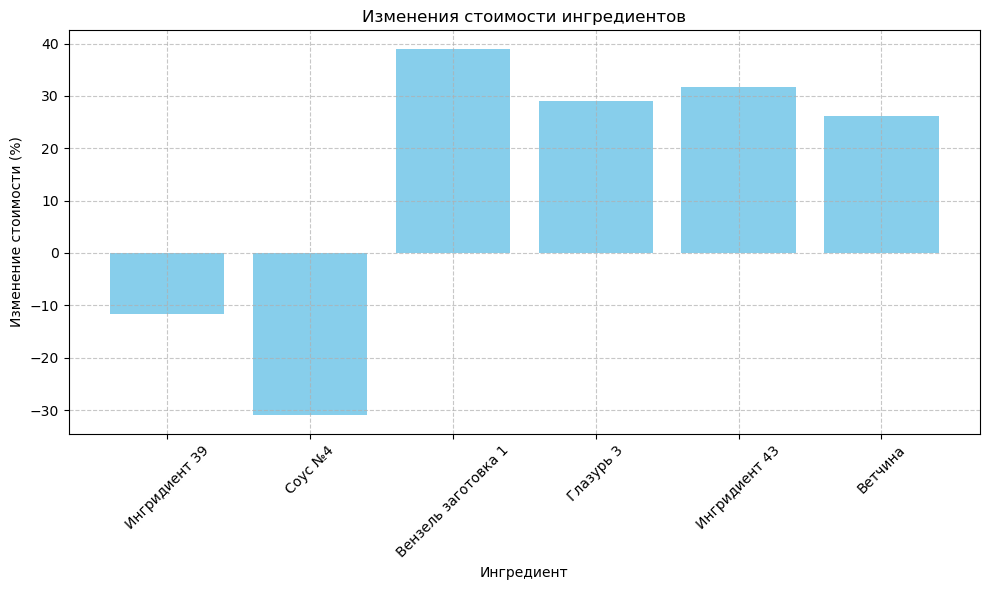

In [33]:
# Выведем изменения в стоимости ингридиентов
plt.figure(figsize=(10, 6))
plt.bar(changes_df['Ингредиент'], changes_df['Изменение стоимости (%)'], color='skyblue')
plt.xlabel('Ингредиент')
plt.ylabel('Изменение стоимости (%)')
plt.title('Изменения стоимости ингредиентов')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


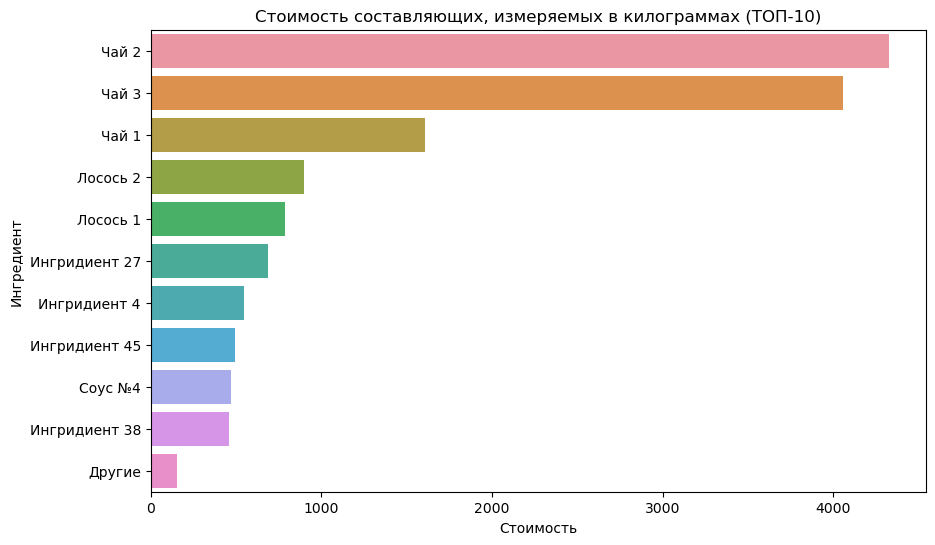

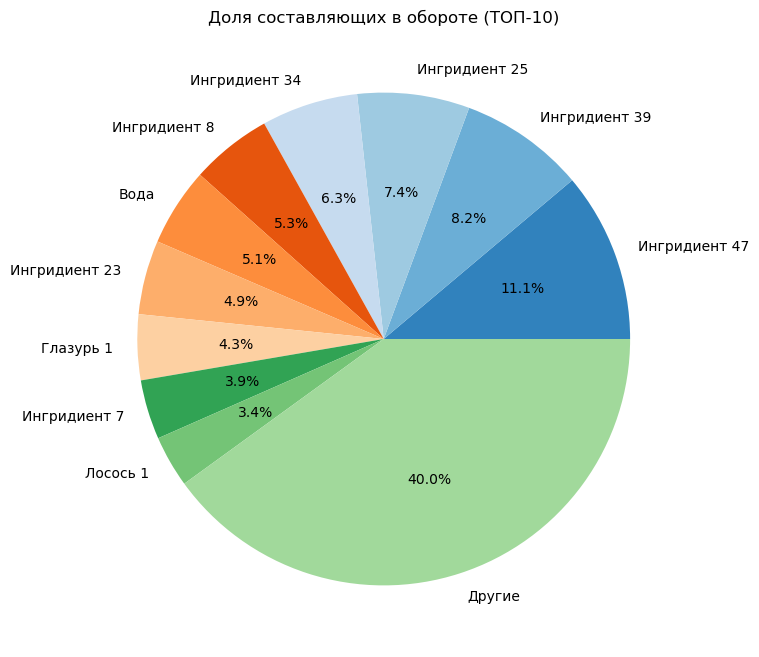

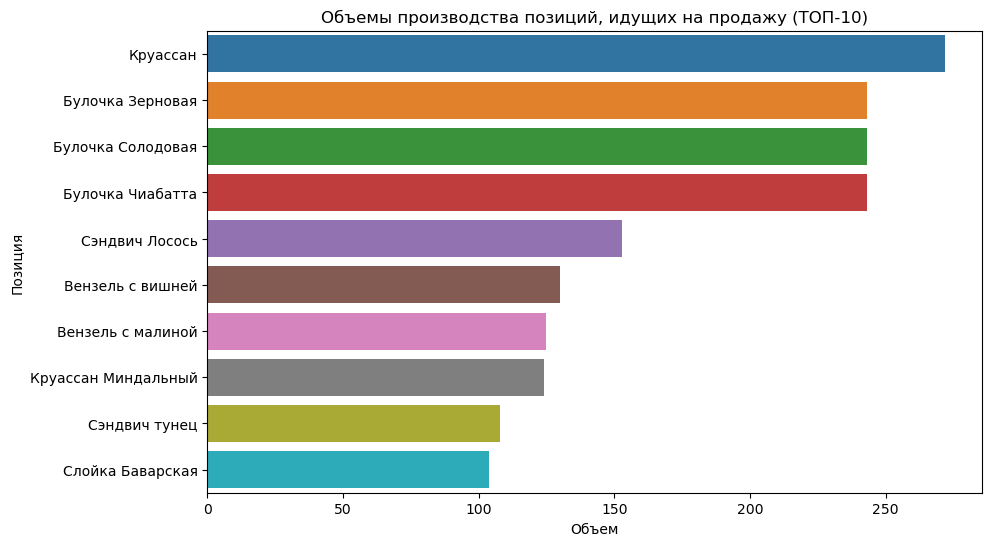

In [37]:
# Анализ составляющих, измеряемых в килограммах
kg_ingredients = data_df[data_df['meit_Name'] == 'кг']
cost_per_kg = kg_ingredients.groupby('pitm_Name')['cdit_Price'].mean()
total_volume_per_kg = kg_ingredients.groupby('pitm_Name')['cdit_Volume'].sum()

# ТОП-10 составляющих по стоимости
top_10_cost_kg = cost_per_kg.nlargest(10)
other_cost_kg = cost_per_kg[~cost_per_kg.index.isin(top_10_cost_kg.index)].mean()
top_10_cost_kg['Другие'] = other_cost_kg

# ТОП-10 составляющих по объему
top_10_volume_kg = total_volume_per_kg.nlargest(10)
other_volume_kg = total_volume_per_kg[~total_volume_per_kg.index.isin(top_10_volume_kg.index)].sum()
top_10_volume_kg['Другие'] = other_volume_kg

# Гистограмма стоимости составляющих
plt.figure(figsize=(10, 6))
colors = plt.cm.tab20c(range(len(top_10_cost_kg)))
sns.barplot(y=top_10_cost_kg.index, x=top_10_cost_kg.values, orient='h')
plt.title('Стоимость составляющих, измеряемых в килограммах (ТОП-10)')
plt.xlabel('Стоимость')
plt.ylabel('Ингредиент')
plt.show()

# Круговая диаграмма доли составляющих в обороте
plt.figure(figsize=(8, 8))
colors = plt.cm.tab20c(range(len(top_10_volume_kg)))  
plt.pie(top_10_volume_kg, labels=top_10_volume_kg.index, autopct='%1.1f%%', colors=colors)
plt.title('Доля составляющих в обороте (ТОП-10)')
plt.show()

# Анализ позиций, идущих на продажу
sales_positions = data_df[data_df['cdit_cdit_ID_Parent'].isnull()]
total_volume_per_position = sales_positions.groupby('pitm_Name')['cdit_Volume'].sum()

# ТОП-10 позиций по объему производства
top_10_volume_position = total_volume_per_position.nlargest(10)

# Столбчатая диаграмма объемов производства позиций
plt.figure(figsize=(10, 6))
colors = plt.cm.tab20c(range(len(top_10_volume_position))) 
sns.barplot(y=top_10_volume_position.index, x=top_10_volume_position.values, orient='h')
plt.title('Объемы производства позиций, идущих на продажу (ТОП-10)')
plt.xlabel('Объем')
plt.ylabel('Позиция')
plt.show()

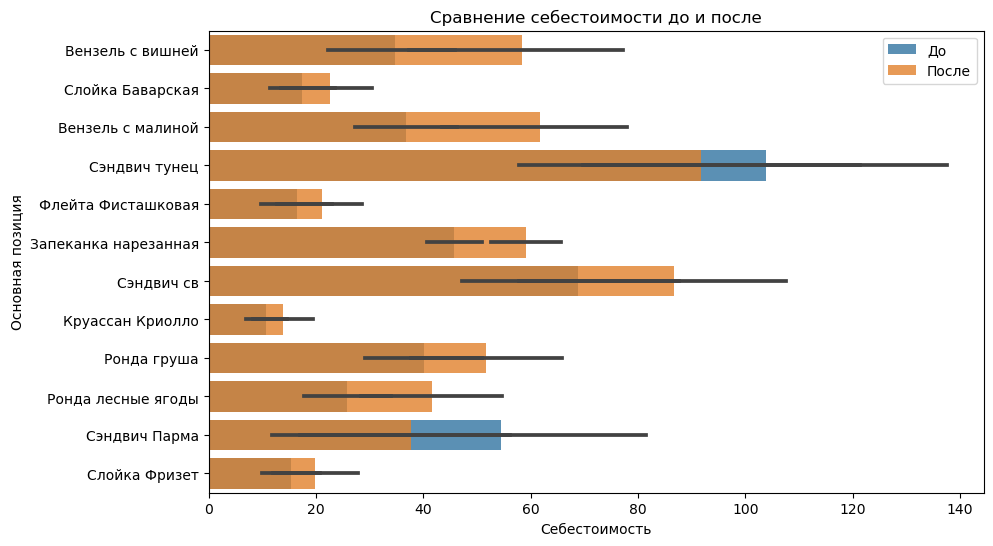

In [42]:
# Столбчатая диаграмма для сравнения себестоимости до и после
plt.figure(figsize=(10, 6))
sns.barplot(y='Основная позиция', x='Средняя себестоимость 1 ед до', data=changed_positions, label='До', color='#1f77b4', alpha=0.8)
sns.barplot(y='Основная позиция', x='Средняя себестоимость 1 ед после', data=changed_positions, label='После', color='#ff7f0e', alpha=0.8)

plt.xlabel('Себестоимость')
plt.ylabel('Основная позиция')
plt.title('Сравнение себестоимости до и после')
plt.legend()
plt.show()

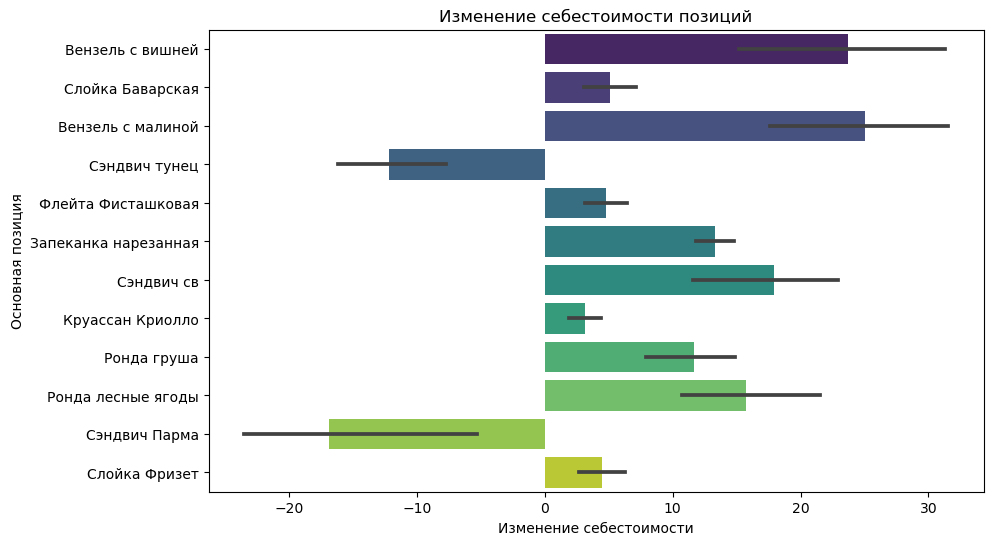

In [43]:
plt.figure(figsize=(10, 6))
sns.barplot(y='Основная позиция', x='Изменение себестоимости', data=changed_positions, palette='viridis')

plt.xlabel('Изменение себестоимости')
plt.ylabel('Основная позиция')
plt.title('Изменение себестоимости позиций')
plt.show()

Основные выводы в презентации.